In [27]:
import numpy as np
import os, glob
import math
import matplotlib
from matplotlib import font_manager
from matplotlib import rc,ticker
from matplotlib import pyplot as plt

from spectres import spectres
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# from astropy.io import fits
# from astropy.table import Table
# from astropy.stats import sigma_clip

# from scipy.integrate import simps
# from scipy import integrate

In [28]:
# Register the font
font_path = '/usr/share/fonts/liberation-sans/LiberationSans-Regular.ttf'
font_manager.fontManager.addfont(font_path)

# Get the actual family name (it must match the internal font name)
liberation = font_manager.FontProperties(fname=font_path)
font_name = liberation.get_name()  # usually "Liberation Sans"
print(font_name)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Set it globally
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name]

plt.rcParams.update({
    'axes.linewidth': 0.5,      # axes spines
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.3,
    'ytick.minor.width': 0.3,
})

Liberation Sans


In [2]:
# file_path = r"D:\Python\JWST\EPISODE\New_result\Astrometry_v4"
# fig_path = r"D:\Python\JWST\EPISODE\New_result\Astrometry_v4\Overleaf"
file_path = '.'
fig_path = '.'
Target='EC53 MIRI-MRS'

file_name_Q = file_path+r'/EC53_Q_MIRI_aperture.txt'
file_name_B = file_path+r'/EC53_B_MIRI_aperture.txt'

In [3]:
def read_file(file_name):
    foo = open(file_name,"r")
    lines = foo.readlines()
    wave_file = []; flux_file = []
    for col1 in lines:
        wave_file.append(col1.split(',')[0])
    for col2 in lines:
        flux_file.append(col2.split(',')[1])
    foo.close
    wave_NIR = np.array(wave_file, np.float64)
    flux_NIR = np.array(flux_file, np.float64)

    # wave_NIR_Q, flux_NIR_Q, fluxE_NIR_Q = np.loadtxt(file_name_NIRSpec_Q,unpack=True,skiprows=1)
    flux_NIR = flux_NIR*1000.
    fluxE_NIR = flux_NIR*10.
        
    return wave_NIR, flux_NIR, fluxE_NIR

wave_MIRI_Q, flux_MIRI_Q, fluxE_MIRI_Q = read_file(file_name_Q)
wave_MIRI_B, flux_MIRI_B, fluxE_MIRI_B = read_file(file_name_B)

########### Smoothing the lab data ##########################
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
#############################################################

ratio = flux_MIRI_B/flux_MIRI_Q; ratio = np.nan_to_num(ratio)
# ratio_sel = np.zeros(len(ratio))
# ratio_sig = smooth(ratio, 50)

# for i in range(len(ratio)):
#     if ((ratio[i]/ratio_sig[i] > 1.03) | (ratio[i]/ratio_sig[i] < 0.97)):
#         ratio_sel[i] = ratio_sig[i]
#     if ((ratio[i]/ratio_sig[i] <= 1.03) & (ratio[i]/ratio_sig[i] >= 0.97)):
#         ratio_sel[i] = ratio[i]
        
# print(ratio,ratio_sig,ratio_sel)



def raio_line_MIRI(wave, flux, degree_num):
    ind_1 = np.where((wave <= 7.75) & (wave >= 6.5))
    ind_2 = np.where((wave <= 13.1) & (wave >= 12.9))
    ind_3 = np.where((wave <= 24.5) & (wave >= 24.))
    ind_4 = np.where((wave <= 27.0) & (wave >= 26.8))


    wave_1 = wave[ind_1]; wave_2 = wave[ind_2]; wave_3 = wave[ind_3]; wave_4 = wave[ind_4]
    flux_1 = flux[ind_1]; flux_2 = flux[ind_2]; flux_3 = flux[ind_3]; flux_4 = flux[ind_4]

    coeff_1=1.; coeff_2=1.

    xp = np.concatenate((wave_1, wave_2, wave_3, wave_4), axis=0)
    yp = np.concatenate((flux_1*coeff_1, flux_2*coeff_2, flux_3, flux_4), axis=0)
 
    degree = degree_num
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    x = xp[:, np.newaxis]
    y = yp[:, np.newaxis]
    model.fit(x,y)

    X_plot = wave[:, np.newaxis]
    y_plot = model.predict(X_plot)
    
    return xp, yp, X_plot, y_plot 

deg_num = 4
xp_MIRI, yp_MIRI, x_train_MIRI, y_train_MIRI = raio_line_MIRI(wave_MIRI_Q, ratio,  deg_num)
cont_Q = y_train_MIRI[:,0] ; print(cont_Q.shape)

flux_MIRI_Q0 = flux_MIRI_Q*cont_Q

deg_num = 5
xp1_MIRI, yp1_MIRI, x_train1_MIRI, y_train1_MIRI = raio_line_MIRI(wave_MIRI_Q, ratio,  deg_num)
cont_Q1 = y_train1_MIRI[:,0] ; print(cont_Q1.shape)

flux_MIRI_Q1 = flux_MIRI_Q*cont_Q1

(10845,)
(10845,)


/home/sjlee/miniforge3/envs/JWST/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.28522e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [4]:
def polynomial_curve_MIR(wave, flux, flux_err, degree_num, 
                         coeff_1, coeff_2, coeff_3, coeff_4, coeff_5, coeff_6, coeff_7, coeff_8):
    ind_1 = np.where((wave <= 5.1) & (wave >= 4.9))
    ind_2 = np.where((wave <= 5.6) & (wave >= 5.4))
    ind_3 = np.where((wave <= 8.) & (wave >= 7.8))
    ind_4 = np.where((wave <= 14.5) & (wave >= 13.)) 
    ind_5 = np.where((wave <= 21.5) & (wave >= 20.))    
    ind_6 = np.where((wave <= 23.5) & (wave >= 22.)) 
    ind_7 = np.where((wave <= 25.8) & (wave >= 24.))
    ind_8 = np.where((wave <= 27.5) & (wave >= 26.1))



    wave_1 = wave[ind_1]; wave_2 = wave[ind_2]; wave_3 = wave[ind_3] 
    wave_4 = wave[ind_4]; wave_5 = wave[ind_5]; wave_6 = wave[ind_6]
    wave_7 = wave[ind_7]; wave_8 = wave[ind_8]
    flux_1 = flux[ind_1]; flux_2 = flux[ind_2]; flux_3 = flux[ind_3] 
    flux_4 = flux[ind_4]; flux_5 = flux[ind_5]; flux_6 = flux[ind_6]
    flux_7 = flux[ind_7]; flux_8 = flux[ind_8]
    fluxErr_1 = flux_err[ind_1]; fluxErr_2 = flux_err[ind_2] 
    fluxErr_3 = flux_err[ind_3]; fluxErr_4 = flux_err[ind_4]
    fluxErr_5 = flux_err[ind_5]; fluxErr_6 = flux_err[ind_6]
    fluxErr_7 = flux_err[ind_7]; fluxErr_8 = flux_err[ind_8]

#     coeff_1=0.95; coeff_2=1.15
#     coeff_3=1.; coeff_4=1.9
#     coeff_5=2.15; coeff_6=1.5; coeff_7=1.58; coeff_8=1.28

#     coeff_1=1.; coeff_2=1.02
#     coeff_3=1.04; coeff_4=2.5
#     coeff_5=1.9; coeff_6=1.6; coeff_7=1.5; coeff_8=1.28    
    
    xp = np.concatenate((wave_1, wave_2, wave_3, wave_4, wave_5, wave_6, wave_7, wave_8), axis=0)
    yp = np.concatenate((flux_1*coeff_1, flux_2*coeff_2, flux_3*coeff_3, flux_4*coeff_4, flux_5*coeff_5, 
                         flux_6*coeff_6, flux_7*coeff_7, flux_8*coeff_8), axis=0)
    yp_dy = np.concatenate((fluxErr_1, fluxErr_2, fluxErr_3, fluxErr_4, fluxErr_5, 
                            fluxErr_6, fluxErr_7, fluxErr_8), axis=0) 
    #plt.plot(xp,yp, 'rD', markersize=2.0, label='Fitting points')
    

    
    degree = degree_num
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    x = xp[:, np.newaxis]
    y = yp[:, np.newaxis]
    #print(x)
    model.fit(x,y)

    X_plot = wave[:, np.newaxis]
    y_plot = model.predict(X_plot)
    #plt.plot(X_plot, y_plot, 'g--', label="Polynomial deg. %d" % degree)
    
    return xp, yp, abs(yp_dy), X_plot, y_plot 

deg_num = 4
coeff_1=0.95; coeff_2=1.15
coeff_3=1.01; coeff_4=1.89
coeff_5=2.35; coeff_6=1.35; coeff_7=1.63; coeff_8=1.26

xp_MIR, yp_MIR, yp_dy_MIR, x_train_MIR, y_train_MIR = polynomial_curve_MIR(wave_MIRI_Q, flux_MIRI_Q0, fluxE_MIRI_Q, deg_num, 
                                                                          coeff_1, coeff_2, coeff_3, coeff_4, 
                                                                          coeff_5, coeff_6, coeff_7, coeff_8)
fluxC_MIR = y_train_MIR[:,0]

flux_c_MIR = flux_MIRI_Q0/y_train_MIR[:,0]
flux_ce_MIR = fluxE_MIRI_Q/(y_train_MIR[:,0])
tau_MIR = -1.0*np.log(flux_c_MIR)
tau_err_MIR = -1.0*np.log(flux_ce_MIR)


coeff_1=1.0; coeff_2=1.05
coeff_3=1.0; coeff_4=1.885
coeff_5=2.26; coeff_6=1.15; coeff_7=1.68; coeff_8=1.22
xp_MIR, yp_MIR, yp_dy_MIR, x_train_MIR, y_train_MIR = polynomial_curve_MIR(wave_MIRI_B, flux_MIRI_B, fluxE_MIRI_B, deg_num, 
                                                                          coeff_1, coeff_2, coeff_3, coeff_4, 
                                                                          coeff_5, coeff_6, coeff_7, coeff_8)
fluxC_MIR_B = y_train_MIR[:,0]

flux_c_MIR_B = flux_MIRI_B/y_train_MIR[:,0]
flux_ce_MIR_B = fluxE_MIRI_B/(y_train_MIR[:,0])
tau_MIR_B = -1.0*np.log(flux_c_MIR_B)
tau_err_MIR_B = -1.0*np.log(flux_ce_MIR_B)

In [5]:
xp1_MIR, yp1_MIR, yp1_dy_MIR, x_train1_MIR, y_train1_MIR = polynomial_curve_MIR(wave_MIRI_Q, flux_MIRI_Q1, fluxE_MIRI_Q, deg_num, 
                                                                          coeff_1, coeff_2, coeff_3, coeff_4, 
                                                                          coeff_5, coeff_6, coeff_7, coeff_8)
fluxC1_MIR = y_train1_MIR[:,0]

flux_c1_MIR = flux_MIRI_Q1/y_train1_MIR[:,0]
flux_ce1_MIR = fluxE_MIRI_Q/(y_train1_MIR[:,0])
tau1_MIR = -1.0*np.log(flux_c1_MIR)
tau1_err_MIR = -1.0*np.log(flux_ce1_MIR)

(6.0, -1.0)

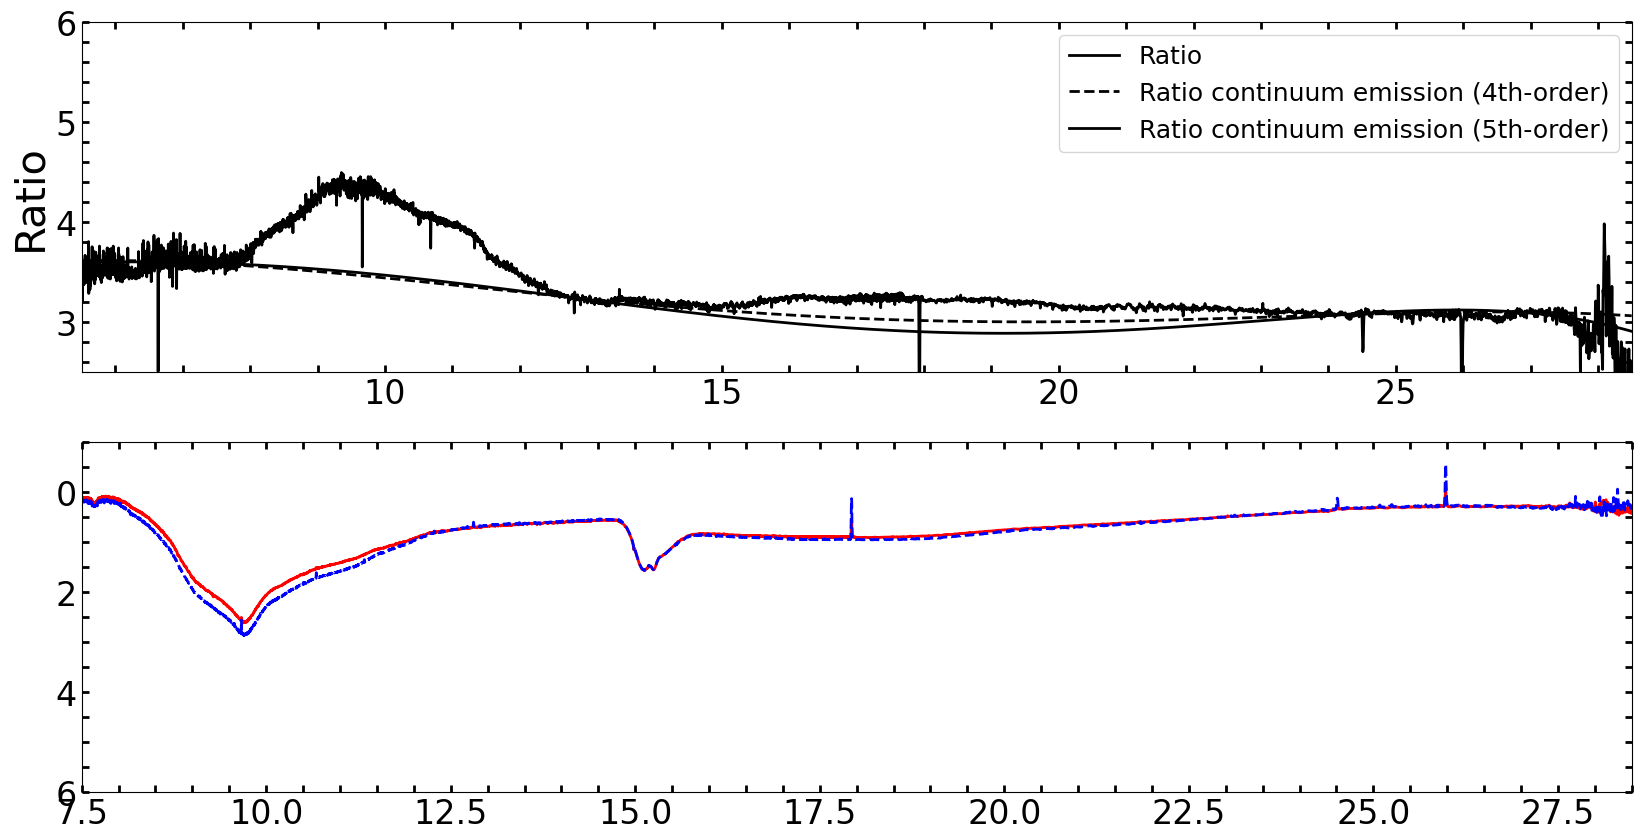

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[20,10])#, gridspec_kw={'height_ratios':[5,5]})
#plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.rc('axes', titlesize=15, labelsize=24)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
# plt.subplots_adjust(hspace=0.)

axes[0].plot(wave_MIRI_B, ratio, color='black',linestyle='-', lw=2, label ='Ratio')
# axes[0].plot(wave_MIR_B, flux1Err_MIR_B, color='red',linestyle='-', lw=2, alpha=0.3)
# axes[0].fill_between(wave_MIR_B, flux1_MIR_B-abs(flux1Err_MIR_B), flux1_MIR_B+abs(flux1Err_MIR_B), color='blue', 
#                       interpolate=True, alpha=0.3)
axes[0].plot(wave_MIRI_B, cont_Q, color='black', linestyle='--', linewidth=2, label="Ratio continuum emission (4th-order)")
axes[0].plot(wave_MIRI_B, cont_Q1, color='black', linestyle='-', linewidth=2, label="Ratio continuum emission (5th-order)")

# axes[0].text(18.5, 1250., 'Burst phase', fontsize=20)


axes[0].set_xlim(5.5, 28.5)
axes[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, width=2, length=5)
axes[0].minorticks_on()
axes[0].set_ylim(2.5, 6.)
axes[0].legend(loc='upper right', fontsize=18)
# axes[0].set_yscale("log")
# axes[0].set_xlabel(r'Wavelength [$\mu$m]', fontsize=20)
axes[0].set_ylabel(r'Ratio', fontsize=30)
# axes[0].set_yticks([1000,2000,3000,4000])
# axes[0].get_yaxis().set_major_formatter(ticker.ScalarFormatter())

# axes[1].plot(wave_MIRI_B, tau_MIR, color='blue',linestyle='-', lw=2, alpha=0.5, label ='Q phase tau')
axes[1].plot(wave_MIRI_B, tau_MIR_B, color='red',linestyle='-', lw=2, label ='B phase tau')
axes[1].plot(wave_MIRI_B, tau1_MIR, color='blue',linestyle='--', lw=2, label ='Q phase tau')

# axes[0].plot(wave_MIR_B, flux1Err_MIR_B, color='red',linestyle='-', lw=2, alpha=0.3)
# axes[0].fill_between(wave_MIR_B, flux1_MIR_B-abs(flux1Err_MIR_B), flux1_MIR_B+abs(flux1Err_MIR_B), color='blue', 
#                       interpolate=True, alpha=0.3)
# axes[0].text(18.5, 1250., 'Burst phase', fontsize=20)


axes[1].set_xlim(7.5, 28.5)
axes[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, width=2, length=5)
axes[1].minorticks_on()
axes[1].set_ylim(6., -1.)

In [8]:
silicate = './New_Silicates_YL.txt'

wave_00, tau_oliv, tau_pyrox, tau_enst = np.loadtxt(silicate,unpack=True)


wave_si = wave_00
tau_si_oliv = tau_oliv
tau_si_pyrox = tau_pyrox


############# Lab. Sli. Coefficients ############
coe_oliv =0.58; coe_pyrox =1.65
coe_oliv_B =0.6; coe_pyrox_B =1.4
#################################################

intp_1d_Tau_oliv = interp1d(wave_si, tau_si_oliv, kind='linear', fill_value="extrapolate")
tau_si0_oliv_cont = intp_1d_Tau_oliv(wave_MIRI_Q)
tau_si_oliv_cont = tau_si0_oliv_cont*coe_oliv
tau_si_oliv_cont = np.nan_to_num(tau_si_oliv_cont)
flux_si_oliv_cont = (np.e**(-1.0*tau_si_oliv_cont))  
flux_si_0_oliv = fluxC_MIR*flux_si_oliv_cont

tauB_si_oliv_cont = tau_si0_oliv_cont*coe_oliv_B
tauB_si_oliv_cont = np.nan_to_num(tauB_si_oliv_cont)
fluxB_si_oliv_cont = (np.e**(-1.0*tauB_si_oliv_cont))  
fluxB_si_0_oliv = fluxC_MIR_B*fluxB_si_oliv_cont


intp_1d_Tau_pyrox = interp1d(wave_si, tau_si_pyrox, kind='linear', fill_value="extrapolate")
tau_si0_pyrox_cont = intp_1d_Tau_pyrox(wave_MIRI_Q)
tau_si_pyrox_cont = tau_si0_pyrox_cont*coe_pyrox
tau_si_pyrox_cont = np.nan_to_num(tau_si_pyrox_cont)        
flux_si_pyrox_cont = (np.e**(-1.0*tau_si_pyrox_cont))  
flux_si_0_pyrox = fluxC_MIR*flux_si_pyrox_cont

tauB_si_pyrox_cont = tau_si0_pyrox_cont*coe_pyrox_B
tauB_si_pyrox_cont = np.nan_to_num(tauB_si_pyrox_cont)        
fluxB_si_pyrox_cont = (np.e**(-1.0*tauB_si_pyrox_cont))  
fluxB_si_0_pyrox = fluxC_MIR_B*fluxB_si_pyrox_cont


flux_si_comb_cont = (np.e**(-1.0*(tau_si_oliv_cont+tau_si_pyrox_cont)))
flux_si_0_comb = fluxC_MIR*(flux_si_comb_cont)
tau_sil_sub = tau_MIR-tau_si_oliv_cont-tau_si_pyrox_cont

fluxB_si_comb_cont = (np.e**(-1.0*(tauB_si_oliv_cont+tauB_si_pyrox_cont)))
fluxB_si_0_comb = fluxC_MIR_B*(fluxB_si_comb_cont)
tauB_sil_sub = tau_MIR_B-tauB_si_oliv_cont-tauB_si_pyrox_cont


In [9]:
#os.chdir(r'./NIRSpec-MIRI')
icefile_dir = './NIRSpec-MIRI'

file_list = os.listdir(icefile_dir)
file_list = sorted(file_list, key=len)

pure_H2O_10K = []; pure_H2O_30K = []; pure_H2O_50K = []; pure_H2O_80K= []; pure_H2O_120K = [] # Amorphous water ice
pure_H2O_160K = [] # Crystalline water ice

mix_H2O_CO2 = [];  mix_H2O_NH3 = []; mix_H2O_CH3OH = []; mix_H2O_CO = [] # Water-rich Ice mixtures for the major ice species
mix_H2O_CH3CHO = []; mix_H2O_CH3CH2OH = []; mix_H2O_CH4 = []
mix_H2O_CH3COOH = []; mix_H2O_NH4COOH = []; mix_H2O_CO_HCOOH = [] # Water-rich Ice mixtures for the minor ice species

###########  Mixed Ice components ###########################
mix_CO_CO2_1_1_CDE = [];mix_CO_CO2_100_70_CDE = []; mix_CO2_CH3OH = []
mix_CO_CH3CHO = []; mix_CO_CH3CH2OH = []; mix_CO_CH3OH = []
mix_NH3_HCOOH_20K = []; mix_NH3_HCOOH_175K = []; mix_CO2_H2O = []
#############################################################

########### Pure ice components #############################
pure_CO2 = []; pure_CO2_CDE_15K = [];  pure_NH3 = []; pure_HCOOH = []
pure_SO2 = []; ion_NH4_12K = []; ion_NH4_80K = []; pure_H2CO = []
pure_CH4 = []; pure_CH3CHO = []; pure_CH3OH = []; pure_CH3CH2OH = []
pure_CO = []; ion_OCN_12K = []; ion_OCN_80K = []; pure_NH2CHO = []
pure_CH3CN = []; pure_CH3NH2 = []
#############################################################

In [11]:
def polynomial_curve(wave, tau, degree_num):
    ind_1 = np.where((wave <= 2.7) & (wave >= 2.4))
    ind_2 = np.where((wave <= 4.0) & (wave >= 3.35))
    ind_3 = np.where((wave <= 5.3) & (wave >= 4.8))
    ind_4 = np.where((wave <= 10.4) & (wave >= 8.8)) #((wave <= 9.9) & (wave >= 8.3))
    #ind_5 = np.where((wave <= 25.) & (wave >= 22.))
    ind_5 = np.where((wave <= 22.) & (wave >= 20.))

    wave_1 = wave[ind_1]; wave_2 = wave[ind_2]; wave_3 = wave[ind_3]; wave_4 = wave[ind_4]; wave_5 = wave[ind_5]
    tau_1 = tau[ind_1]; tau_2 = tau[ind_2]; tau_3 = tau[ind_3]; tau_4 = tau[ind_4]; tau_5 = tau[ind_5]

    xp = np.concatenate((wave_1, wave_2, wave_3, wave_4, wave_5), axis=0)
    yp = np.concatenate((tau_1, tau_2, tau_3, tau_4, tau_5), axis=0)


    degree = degree_num
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    x = xp[:, np.newaxis]
    y = yp[:, np.newaxis]
    #print(x)
    model.fit(x,y)

    X_plot = wave[:, np.newaxis]
    y_plot = model.predict(X_plot)
    #axes[0].plot(X_plot, y_plot, 'b-', label="Continuum")

    return X_plot, y_plot 

def base_fit_poly(wave, tau, degree_num, 
                     wl1_min, wl1_max, wl2_min, wl2_max, wl3_min, wl3_max, wl4_min, wl4_max, wl5_min, wl5_max, wl6_min, wl6_max):
    ind_1 = np.where((wave <= wl1_max) & (wave >= wl1_min))
    ind_2 = np.where((wave <= wl2_max) & (wave >= wl2_min))
    ind_3 = np.where((wave <= wl3_max) & (wave >= wl3_min))
    ind_4 = np.where((wave <= wl4_max) & (wave >= wl4_min)) #((wave <= 9.9) & (wave >= 8.3))
    ind_5 = np.where((wave <= wl5_max) & (wave >= wl5_min))
    ind_6 = np.where((wave <= wl6_max) & (wave >= wl6_min))

    wave_1 = wave[ind_1]; wave_2 = wave[ind_2]; wave_3 = wave[ind_3]; wave_4 = wave[ind_4]; wave_5 = wave[ind_5]; wave_6 = wave[ind_6]
    tau_1 = tau[ind_1]; tau_2 = tau[ind_2]; tau_3 = tau[ind_3]; tau_4 = tau[ind_4]; tau_5 = tau[ind_5]; tau_6 = tau[ind_6]

    xp = np.concatenate((wave_1, wave_2, wave_3, wave_4, wave_5, wave_6), axis=0)
    yp = np.concatenate((tau_1, tau_2, tau_3, tau_4, tau_5, tau_6), axis=0)


    degree = degree_num
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    x = xp[:, np.newaxis]
    y = yp[:, np.newaxis]
    #print(x)
    model.fit(x,y)

    X_plot = wave[:, np.newaxis]
    y_plot = model.predict(X_plot)
    #axes[0].plot(X_plot, y_plot, 'b-', label="Continuum")

    return X_plot, y_plot 



In [15]:
########## 10 K #############################
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Pure_H2O_10K'):
        pure_H2O_10K.append(file_list[i]); print(pure_H2O_10K[ii])
        f = open(icefile_dir+'/'+pure_H2O_10K[ii],"r")
        ice_comp_pure_H2O_10K = str(pure_H2O_10K[ii])
        lines = f.readlines()
        freq_lab = []; abs_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            freq_lab.append(col1.split()[0])
        for col2 in lines:
            abs_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        freq_lab = np.array(freq_lab, np.float64)
        wave_lab = 10000./freq_lab
        abs_lab = np.array(abs_lab, np.float64)
        tau_lab = -1.0*np.log(np.exp(-1.0*abs_lab))#; print(tau_lab)
        
        sort_L = np.argsort(wave_lab)
        wave_lab_pure_H2O_10K = np.sort(wave_lab)#-0.01
        tau_lab_pure_H2O_10K = tau_lab[sort_L]
        coe_pure_H2O_10K = 22.63 #24.1 max=25.5
        
scaled_tau_lab_pure_H2O_10K = tau_lab_pure_H2O_10K*coe_pure_H2O_10K

wave_subt, tau_subt = polynomial_curve(wave_lab_pure_H2O_10K, scaled_tau_lab_pure_H2O_10K, 6)
wave_subt_pure_H2O_10K = wave_subt[:,0]; tau_subt_pure_H2O_10K = tau_subt[:,0]
corrected0_tau_lab_pure_H2O_10K = scaled_tau_lab_pure_H2O_10K-tau_subt_pure_H2O_10K 


corrected_tau_lab_pure_H2O_10K = spectres(wave_MIRI_B, wave_lab_pure_H2O_10K, corrected0_tau_lab_pure_H2O_10K)
corrected_tau_lab_pure_H2O_10K = np.nan_to_num(corrected_tau_lab_pure_H2O_10K)


ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Pure_H2O_160K'):
        pure_H2O_160K.append(file_list[i]); print(pure_H2O_160K[ii])
        f = open(icefile_dir+'/'+pure_H2O_160K[ii],"r")
        ice_comp_pure_H2O_160K = str(pure_H2O_160K[ii])
        lines = f.readlines()
        freq_lab = []; abs_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            freq_lab.append(col1.split()[0])
        for col2 in lines:
            abs_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        freq_lab = np.array(freq_lab, np.float64)
        wave_lab = 10000./freq_lab
        abs_lab = np.array(abs_lab, np.float64)
        tau_lab = -1.0*np.log(np.exp(-1.0*abs_lab))#; print(tau_lab)
        
        sort_L = np.argsort(wave_lab)
        wave_lab_pure_H2O_160K = np.sort(wave_lab)#-0.01
        tau_lab_pure_H2O_160K = tau_lab[sort_L]
        
scaled_tau_lab_pure_H2O_160K = tau_lab_pure_H2O_160K*1.44*1.071 #1.31  max=6.1
corrected_tau_lab_pure_H2O_160K = spectres(wave_MIRI_B, wave_lab_pure_H2O_160K, scaled_tau_lab_pure_H2O_160K)
corrected_tau_lab_pure_H2O_160K = np.nan_to_num(corrected_tau_lab_pure_H2O_160K)



Pure_H2O_10K.txt
Pure_H2O_160K.txt


/home/sjlee/miniforge3/envs/JWST/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.38565e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/sjlee/miniforge3/envs/JWST/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


In [17]:

########## CH3OH-based ##########
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CH3OH_CO2_1_1_1_10K_optim_IR_final'):
        mix_CO2_CH3OH.append(file_list[i])
        f = open(icefile_dir+'/'+mix_CO2_CH3OH[ii], "r"); print(mix_CO2_CH3OH[ii])
        ice_comp_mix_CO2_CH3OH = str(mix_CO2_CH3OH[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_CO2_CH3OH = 0.861 #0.77
        
optimized_tau_lab_mix_CO2_CH3OH = tau_lab*coe_mix_CO2_CH3OH
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_CO2_CH3OH)
optimized_tau_lab_mix_CO2_CH3OH = (lab_to_JWST) 

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_CO_CH3OH_1_1_15K_optim_IR_final'):
        mix_CO_CH3OH.append(file_list[i])
        f = open(icefile_dir+'/'+mix_CO_CH3OH[ii], "r"); print(mix_CO_CH3OH[ii])
        ice_comp_mix_CO_CH3OH = str(mix_CO_CH3OH[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_CO_CH3OH = 0.634  # 0.4 0.55 0.6
        
optimized_tau_lab_mix_CO_CH3OH = tau_lab*coe_mix_CO_CH3OH
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_CO_CH3OH)
optimized_tau_lab_mix_CO_CH3OH = (lab_to_JWST) 

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_CH3OH_15K_new_optim_IR_final'):
        pure_CH3OH.append(file_list[i])
        f = open(icefile_dir+'/'+pure_CH3OH[ii], "r"); print(pure_CH3OH[ii])
        ice_comp_pure_CH3OH = str(pure_CH3OH[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_pure_CH3OH = 0.183 #1.4 0.85 0.75 0.85
        
optimized_tau_lab_pure_CH3OH = tau_lab*coe_pure_CH3OH
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_pure_CH3OH)
optimized_tau_lab_pure_CH3OH = (lab_to_JWST)+0.01 



 


############# W-rich CO2
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CO2_100_14_10K_optim_IR_final'):
        mix_H2O_CO2.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_CO2[ii], "r"); print(mix_H2O_CO2[ii])
        ice_comp_mix_H2O_CO2 = str(mix_H2O_CO2[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_CO2 = 0.950 #1.32
        
optimized_tau_lab_mix_H2O_CO2 = tau_lab*coe_mix_H2O_CO2
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_CO2)
optimized_tau_lab_mix_H2O_CO2 = (lab_to_JWST) 

########### W-rich CO
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CO_100_20_10K_optim_IR_final'):
        mix_H2O_CO.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_CO[ii], "r"); print(mix_H2O_CO[ii])
        ice_comp_mix_H2O_CO = str(mix_H2O_CO[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_CO = 0. #1.32  0.5
        
optimized_tau_lab_mix_H2O_CO = tau_lab*coe_mix_H2O_CO
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_CO)
optimized_tau_lab_mix_H2O_CO = (lab_to_JWST) 

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CO_HCOOH_62_30_8_15K_optim_IR_final'):
        mix_H2O_CO_HCOOH.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_CO_HCOOH[ii], "r"); print(mix_H2O_CO_HCOOH[ii])
        ice_comp_mix_H2O_CO_HCOOH = str(mix_H2O_CO_HCOOH[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_CO_HCOOH =0.6 #0.4
        
optimized_tau_lab_mix_H2O_CO_HCOOH = tau_lab*coe_mix_H2O_CO_HCOOH
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_CO_HCOOH)
optimized_tau_lab_mix_H2O_CO_HCOOH = (lab_to_JWST)



### W-rich CH3CHO ################
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CH3CHO_20_1_15K_optim_IR_final'):
        mix_H2O_CH3CHO.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_CH3CHO[ii], "r"); print(mix_H2O_CH3CHO[ii])
        ice_comp_mix_H2O_CH3CHO = str(mix_H2O_CH3CHO[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_CH3CHO = 0.1#0.5
        
optimized_tau_lab_mix_H2O_CH3CHO = tau_lab*coe_mix_H2O_CH3CHO
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_CH3CHO)
optimized_tau_lab_mix_H2O_CH3CHO = (lab_to_JWST) 

Tau_H2O_CH3OH_CO2_1_1_1_10K_optim_IR_final.txt
Tau_CO_CH3OH_1_1_15K_optim_IR_final.txt


/home/sjlee/miniforge3/envs/JWST/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


Tau_Pure_CH3OH_15K_new_optim_IR_final.txt
Tau_H2O_CO2_100_14_10K_optim_IR_final.txt
Tau_H2O_CO_100_20_10K_optim_IR_final.txt
Tau_H2O_CO_HCOOH_62_30_8_15K_optim_IR_final.txt
Tau_H2O_CH3CHO_20_1_15K_optim_IR_final.txt


In [18]:

####### CO2-based

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_CO2_vanBroekhuizen_15K_Trimming_NorCDE_optim_IR_final'):
        pure_CO2_CDE_15K.append(file_list[i])
        f = open(icefile_dir+'/'+pure_CO2_CDE_15K[ii], "r"); print(pure_CO2_CDE_15K[ii])
        ice_comp_pure_CO2_CDE_15K = str(pure_CO2_CDE_15K[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_pure_CO2_CDE_15K = 0.785 #1.32
        
optimized_tau_lab_pure_CO2_CDE_15K = tau_lab*coe_pure_CO2_CDE_15K
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_pure_CO2_CDE_15K)
optimized_tau_lab_pure_CO2_CDE_15K = (lab_to_JWST) 
optimized_tau_lab_pure_CO2_CDE_15K = np.nan_to_num(optimized_tau_lab_pure_CO2_CDE_15K)

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_CO_CO2_1_1_15K_Trimming_optim_IR_final'):
        mix_CO_CO2_1_1_CDE.append(file_list[i])
        f = open(icefile_dir+'/'+mix_CO_CO2_1_1_CDE[ii], "r"); print(mix_CO_CO2_1_1_CDE[ii])
        ice_comp_mix_CO_CO2_1_1_CDE = str(mix_CO_CO2_1_1_CDE[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_CO_CO2_1_1_CDE = 0.822 #1.32
        
scaled_tau_lab_mix_CO_CO2_1_1_CDE = tau_lab*coe_mix_CO_CO2_1_1_CDE
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, scaled_tau_lab_mix_CO_CO2_1_1_CDE)
optimized_tau_lab_mix_CO_CO2_1_1_CDE = (lab_to_JWST) 
optimized_tau_lab_mix_CO_CO2_1_1_CDE = np.nan_to_num(optimized_tau_lab_mix_CO_CO2_1_1_CDE)

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('CO2_CO_70_100_CDE_nor'):
        mix_CO_CO2_100_70_CDE.append(file_list[i])
        f = open(icefile_dir+'/'+mix_CO_CO2_100_70_CDE[ii], "r"); print(mix_CO_CO2_100_70_CDE[ii])
        ice_comp_mix_CO_CO2_100_70_CDE = str(mix_CO_CO2_100_70_CDE[ii])
        lines = f.readlines()
        freq_lab = []; abs_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            freq_lab.append(col1.split()[0])
        for col2 in lines:
            abs_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        freq_lab = np.array(freq_lab, np.float64)
        wave_lab = 10000./freq_lab
        abs_lab = np.array(abs_lab, np.float64)
        tau_lab = -1.0*np.log(np.exp(-1.0*abs_lab))
        
        sort_L = np.argsort(wave_lab)
        wave_lab_mix_CO_CO2_100_70_CDE = np.sort(wave_lab)#-0.01
        tau_lab_mix_CO_CO2_100_70_CDE = tau_lab[sort_L]
        coe_mix_CO_CO2_100_70_CDE = 0.203 # 0.21

lab_to_JWST = spectres(wave_MIRI_B, wave_lab_mix_CO_CO2_100_70_CDE, tau_lab_mix_CO_CO2_100_70_CDE)        
optimized_tau_lab_mix_CO_CO2_100_70_CDE = lab_to_JWST*coe_mix_CO_CO2_100_70_CDE 
optimized_tau_lab_mix_CO_CO2_100_70_CDE = np.nan_to_num(optimized_tau_lab_mix_CO_CO2_100_70_CDE)


Tau_Pure_CO2_vanBroekhuizen_15K_Trimming_NorCDE_optim_IR_final.txt
Tau_CO_CO2_1_1_15K_Trimming_optim_IR_final.txt


/home/sjlee/miniforge3/envs/JWST/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


CO2_CO_70_100_CDE_nor.txt


In [19]:

### NH3-based ###########
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_NH3_10K_optim_IR_final'):
        pure_NH3.append(file_list[i])
        f = open(icefile_dir+'/'+pure_NH3[ii], "r"); print(pure_NH3[ii])
        ice_comp_pure_NH3 = str(pure_NH3[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_pure_NH3 = 0.7 #1.1*0.543 #0.85
        
optimized_tau_lab_pure_NH3 = tau_lab*coe_pure_NH3
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_pure_NH3)
optimized_tau_lab_pure_NH3 = (lab_to_JWST) 

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_NH3_100_20_10K_optim_IR_final'):
        mix_H2O_NH3.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_NH3[ii], "r"); print(mix_H2O_NH3[ii])
        ice_comp_mix_H2O_NH3 = str(mix_H2O_NH3[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_NH3 = 0.75 # 0.8
        
optimized_tau_lab_mix_H2O_NH3 = tau_lab*coe_mix_H2O_NH3
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_NH3)
optimized_tau_lab_mix_H2O_NH3 = (lab_to_JWST)


### CH3CH2OH ##########
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_CH3CH2OH_15K_optim_IR_final'):
        pure_CH3CH2OH.append(file_list[i])
        f = open(icefile_dir+'/'+pure_CH3CH2OH[ii], "r"); print(pure_CH3CH2OH[ii])
        ice_comp_pure_CH3CH2OH = str(pure_CH3CH2OH[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_pure_CH3CH2OH = 1.3 #0.85
        
optimized_tau_lab_pure_CH3CH2OH = tau_lab*coe_pure_CH3CH2OH
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_pure_CH3CH2OH)
optimized_tau_lab_pure_CH3CH2OH = (lab_to_JWST) 


### CO ################
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_CO_15K_optim_IR_final'):
        pure_CO.append(file_list[i])
        f = open(icefile_dir+'/'+pure_CO[ii], "r"); print(pure_CO[ii])
        ice_comp_pure_CO = str(pure_CO[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_pure_CO = 0.454 #1.32
        
optimized_tau_lab_pure_CO = tau_lab*coe_pure_CO
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_pure_CO)
optimized_tau_lab_pure_CO = (lab_to_JWST) 

Tau_Pure_NH3_10K_optim_IR_final.txt
Tau_H2O_NH3_100_20_10K_optim_IR_final.txt
Tau_Pure_CH3CH2OH_15K_optim_IR_final.txt
Tau_Pure_CO_15K_optim_IR_final.txt


In [20]:
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_OCN_12K_optim_IR_v1a'):
        ion_OCN_12K.append(file_list[i])
        f = open(icefile_dir+'/'+ion_OCN_12K[ii], "r"); print(ion_OCN_12K[ii])
        ice_comp_ion_OCN_12K = str(ion_OCN_12K[ii])
        lines = f.readlines()
        wave_lab0 = []; tau_lab0=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab0.append(col1.split()[0])
        for col2 in lines:
            tau_lab0.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab0, np.float64)
        tau_lab = np.array(tau_lab0, np.float64)
        
        sort_L = np.argsort(wave_lab)
        wave_lab = np.sort(wave_lab)#-0.01
        tau_lab = tau_lab[sort_L]
        coe_tau_lab_ion_OCN_12K = 0.05

scaled_tau_lab_ion_OCN_12K = tau_lab*coe_tau_lab_ion_OCN_12K
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, scaled_tau_lab_ion_OCN_12K)
corrected_tau_lab_ion_OCN_12K = (lab_to_JWST)        
corrected_tau_lab_ion_OCN_12K = np.nan_to_num(corrected_tau_lab_ion_OCN_12K)  

Tau_Pure_OCN_12K_optim_IR_v1a.txt


In [22]:
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_NH4p_80K_optim_IR_v2a'):
        ion_NH4_80K.append(file_list[i])
        f = open(icefile_dir+'/'+ion_NH4_80K[ii], "r"); print(ion_NH4_80K[ii])
        ice_comp_ion_NH4_80K = str(ion_NH4_80K[ii])
        lines = f.readlines()
        wave_lab0 = []; tau_lab0=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab0.append(col1.split()[0])
        for col2 in lines:
            tau_lab0.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab0, np.float64)
        tau_lab = np.array(tau_lab0, np.float64)
        
        sort_L = np.argsort(wave_lab)
        wave_lab = np.sort(wave_lab)#-0.01
        tau_lab = tau_lab[sort_L]
        coe_tau_lab_ion_NH4_80K = 0.125*0.762*1.25

scaled_tau_lab_ion_NH4_80K = tau_lab*coe_tau_lab_ion_NH4_80K
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, scaled_tau_lab_ion_NH4_80K)
corrected_tau_lab_ion_NH4_80K = (lab_to_JWST)        
corrected_tau_lab_ion_NH4_80K = np.nan_to_num(corrected_tau_lab_ion_NH4_80K)

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_HNCH_NH3_12K_optim_IR_v2a'):
        ion_NH4_12K.append(file_list[i])
        f = open(icefile_dir+'/'+ion_NH4_12K[ii], "r"); print(ion_NH4_12K[ii])
        ice_comp_ion_NH4_12K = str(ion_NH4_12K[ii])
        lines = f.readlines()
        wave_lab0 = []; tau_lab0=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab0.append(col1.split()[0])
        for col2 in lines:
            tau_lab0.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab0, np.float64)
        tau_lab = np.array(tau_lab0, np.float64)
        
        sort_L = np.argsort(wave_lab)
        wave_lab = np.sort(wave_lab)#-0.01
        tau_lab = tau_lab[sort_L]
        coe_tau_lab_ion_NH4_12K = 0.45*1.058

scaled_tau_lab_ion_NH4_12K = tau_lab*coe_tau_lab_ion_NH4_12K
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, scaled_tau_lab_ion_NH4_12K)
corrected_tau_lab_ion_NH4_12K = (lab_to_JWST)        
corrected_tau_lab_ion_NH4_12K = np.nan_to_num(corrected_tau_lab_ion_NH4_12K)



Tau_NH4p_80K_optim_IR_v2a.txt
Tau_HNCH_NH3_12K_optim_IR_v2a.txt


In [23]:
ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CH3COOH_10_1_16K_optim_IR_final'):
        mix_H2O_CH3COOH.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_CH3COOH[ii], "r"); print(mix_H2O_CH3COOH[ii])
        ice_comp_mix_H2O_CH3COOH = str(mix_H2O_CH3COOH[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_CH3COOH = 0.55
        
optimized_tau_lab_mix_H2O_CH3COOH = tau_lab*coe_mix_H2O_CH3COOH
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_CH3COOH)
optimized_tau_lab_mix_H2O_CH3COOH = (lab_to_JWST) 


ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_H2O_CH4_100_33_10K_optim_IR_final'):
        mix_H2O_CH4.append(file_list[i])
        f = open(icefile_dir+'/'+mix_H2O_CH4[ii], "r"); print(mix_H2O_CH4[ii])
        ice_comp_mix_H2O_CH4 = str(mix_H2O_CH4[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_mix_H2O_CH4 = 0.8*0.872 #0.5
        
optimized_tau_lab_mix_H2O_CH4 = tau_lab*coe_mix_H2O_CH4
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_mix_H2O_CH4)
optimized_tau_lab_mix_H2O_CH4 = (lab_to_JWST) 

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Tau_Pure_H2CO_10K_optim_IR_final'):
        pure_H2CO.append(file_list[i])
        f = open(icefile_dir+'/'+pure_H2CO[ii], "r"); print(pure_H2CO[ii])
        ice_comp_pure_H2CO = str(pure_H2CO[ii])
        lines = f.readlines()
        wave_lab = []; tau_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            wave_lab.append(col1.split()[0])
        for col2 in lines:
            tau_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        wave_lab = np.array(wave_lab, np.float64)
        tau_lab = np.array(tau_lab, np.float64)
        coe_pure_H2CO = 1.*0.678*1.3#0.5
        
optimized_tau_lab_pure_H2CO = tau_lab*coe_pure_H2CO
lab_to_JWST = spectres(wave_MIRI_B, wave_lab, optimized_tau_lab_pure_H2CO)
optimized_tau_lab_pure_H2CO = (lab_to_JWST) 

ii=0
for i in range(len(file_list)):
    if file_list[i].startswith('Pure_NH2CHO_15K'):
        pure_NH2CHO.append(file_list[i]); print(pure_NH2CHO[ii])
        f = open(icefile_dir+'/'+pure_NH2CHO[ii],"r")
        ice_comp_pure_NH2CHO = str(pure_NH2CHO[ii])
        lines = f.readlines()
        freq_lab = []; abs_lab=[]#; wave_lab_H2O=[]; wave_lab_H2O=[]; lab_to_AKARI=[]
        for col1 in lines:
            freq_lab.append(col1.split()[0])
        for col2 in lines:
            abs_lab.append(col2.split()[1])
        f.close
        #print(wave_lab)
        freq_lab = np.array(freq_lab, np.float64)
        wave_lab = 10000./freq_lab
        abs_lab = np.array(abs_lab, np.float64)
        tau_lab = -1.0*np.log(np.exp(-1.0*abs_lab))#; print(tau_lab)
        
        sort_L = np.argsort(wave_lab)
        wave_lab_pure_NH2CHO = np.sort(wave_lab)#-0.01
        tau_lab_pure_NH2CHO = tau_lab[sort_L]
        coe_pure_NH2CHO =0.3
        
scaled_tau_lab_pure_NH2CHO = tau_lab_pure_NH2CHO*coe_pure_NH2CHO
optimized_tau_lab_pure_NH2CHO = spectres(wave_MIRI_B, wave_lab_pure_NH2CHO, scaled_tau_lab_pure_NH2CHO)
optimized_tau_lab_pure_NH2CHO = np.nan_to_num(optimized_tau_lab_pure_NH2CHO)

Tau_H2O_CH3COOH_10_1_16K_optim_IR_final.txt
Tau_H2O_CH4_100_33_10K_optim_IR_final.txt
Tau_Pure_H2CO_10K_optim_IR_final.txt
Pure_NH2CHO_15K.txt


In [24]:
fluxErr_MIRI_Q = np.diff(flux_MIRI_Q, append=flux_MIRI_Q[-1]); sigma_diff_Q = np.std(fluxErr_MIRI_Q) / np.sqrt(2)
fluxErr_MIRI_B = np.diff(flux_MIRI_B, append=flux_MIRI_B[-1]); sigma_diff_B = np.std(fluxErr_MIRI_B) / np.sqrt(2)
print(sigma_diff_Q, sigma_diff_B)
sigma_diff_QT = np.std(tau_err_MIR) / np.sqrt(2)
sigma_diff_BT = np.std(tau_err_MIR_B) / np.sqrt(2)
print(sigma_diff_QT,sigma_diff_BT)

12.027227430634614 16.73514742648956
0.4750933567463528 0.43581344807929767


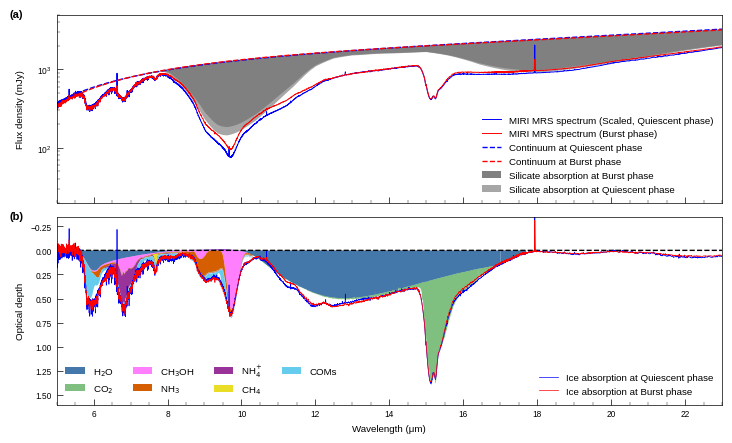

In [98]:
fig, axs = plt.subplots(2, 1, figsize=(18.3/2.54, 18.3/2.54*0.6), constrained_layout=True, sharex=True)


axs[0].plot(wave_MIRI_Q, flux_MIRI_Q0, color='blue', lw=0.7, label ='MIRI MRS spectrum (Scaled, Quiescent phase)')
axs[0].plot(wave_MIRI_B, flux_MIRI_B, color='red', lw=0.7, label ='MIRI MRS spectrum (Burst phase)')

axs[0].plot(wave_MIRI_Q, fluxC_MIR, color='blue', linestyle='--', lw=1, label ='Continuum at Quiescent phase')
axs[0].plot(wave_MIRI_B, fluxC_MIR_B, color='red', linestyle='--', lw=1, label ='Continuum at Burst phase')

axs[0].fill_between(wave_MIRI_B, fluxC_MIR_B, fluxB_si_0_comb,
                    interpolate=True, alpha=1., color='gray', label='Silicate absorption at Burst phase', ec=None)
axs[0].fill_between(wave_MIRI_Q, fluxC_MIR, flux_si_0_comb,
                    interpolate=True, alpha=0.7, color='gray', label='Silicate absorption at Quiescent phase', ec=None)

axs[0].set_xlim(5.0, 23.)
axs[0].set_ylim(20.,5000.)
axs[0].set_yscale('log')

axs[0].tick_params(axis='both', which='major', labelsize=6, length=4, direction='in')
axs[0].tick_params(axis='both', which='minor', length=2, direction='in')
axs[0].set_ylabel(r'Flux density (mJy)', fontsize=7)
axs[0].legend(loc='lower right', fontsize=7, frameon=False)


#--------------------------------------------------------------------------

zeroline = np.zeros(len(wave_MIRI_Q))

axs[1].plot(wave_MIRI_Q, zeroline, 'k--', lw=1.)
line1, = axs[1].plot(wave_MIRI_Q, tau_sil_sub, color='blue', lw=0.5, label='Ice absorption at Quiescent phase')
line2, = axs[1].plot(wave_MIRI_Q, tauB_sil_sub, color='red', lw=0.5, label='Ice absorption at Burst phase')

ind_H2O = np.where((wave_MIRI_B <=17.0))
axs[1].fill_between(wave_MIRI_B[ind_H2O], zeroline[ind_H2O], 
                      corrected_tau_lab_pure_H2O_10K[ind_H2O]*0.935+corrected_tau_lab_pure_H2O_160K[ind_H2O],
                   color="#4477aa", alpha=1, ec=None, label=r'H$_{2}$O')
ind_H2O_1 = np.where((wave_MIRI_B > 17.0) & (wave_MIRI_B <=17.7))
axs[1].fill_between(wave_MIRI_B[ind_H2O_1], zeroline[ind_H2O_1], 
                      tauB_sil_sub[ind_H2O_1],
                   color="#4477aa", alpha=1, ec=None)
                      
ice_water = corrected_tau_lab_pure_H2O_10K*0.935+corrected_tau_lab_pure_H2O_160K

ind_CO2 = np.where((wave_MIRI_B >= 10.2) & (wave_MIRI_B <=16.4))

axs[1].fill_between(wave_MIRI_B[ind_CO2], ice_water[ind_CO2], ice_water[ind_CO2]+
                      optimized_tau_lab_mix_CO2_CH3OH[ind_CO2]+optimized_tau_lab_mix_H2O_CO2[ind_CO2]+
                     (optimized_tau_lab_mix_CO_CO2_1_1_CDE[ind_CO2])+(optimized_tau_lab_mix_CO_CO2_100_70_CDE[ind_CO2])+
                     optimized_tau_lab_pure_CO2_CDE_15K[ind_CO2]*1.,
                   color='green', alpha=0.5, ec=None, label=r'CO$_{2}$')
ice_CO2 = (optimized_tau_lab_mix_H2O_CO2+optimized_tau_lab_mix_CO_CO2_1_1_CDE+
           optimized_tau_lab_mix_CO_CO2_100_70_CDE+optimized_tau_lab_pure_CO2_CDE_15K)

ind_CO2_1 = np.where((wave_MIRI_B > 16.4) & (wave_MIRI_B <=16.8))
axs[1].fill_between(wave_MIRI_B[ind_CO2_1], ice_water[ind_CO2_1], 
                      tauB_sil_sub[ind_CO2_1],
                   color='green', alpha=0.5, ec=None)

ind_CH3OH = np.where((wave_MIRI_B >= 5.5) & (wave_MIRI_B <=10.3))
axs[1].fill_between(wave_MIRI_B[ind_CH3OH], ice_water[ind_CH3OH], ice_water[ind_CH3OH]+optimized_tau_lab_mix_CO2_CH3OH[ind_CH3OH]+
                     optimized_tau_lab_mix_CO_CH3OH[ind_CH3OH]+optimized_tau_lab_pure_CH3OH[ind_CH3OH],
                      color='magenta', alpha=0.5, ec=None, label=r'CH$_{3}$OH')

ice_methanol = optimized_tau_lab_mix_CO2_CH3OH+optimized_tau_lab_mix_CO_CH3OH+optimized_tau_lab_pure_CH3OH
ind_NH3 = np.where((wave_MIRI_B >= 5.5) & (wave_MIRI_B <=10.3))
axs[1].fill_between(wave_MIRI_B[ind_NH3], ice_water[ind_NH3]+ice_methanol[ind_NH3], 
                      ice_water[ind_NH3]+ice_methanol[ind_NH3]+
                     optimized_tau_lab_pure_NH3[ind_NH3]*0.98+optimized_tau_lab_mix_H2O_NH3[ind_NH3]*0.99,
                   color='#d55e00', alpha=1, ec=None, label=r'NH$_{3}$')

ice_ammonia = optimized_tau_lab_pure_NH3*0.98+optimized_tau_lab_mix_H2O_NH3*0.99
ind_7mic = np.where((wave_MIRI_B >= 5.5) & (wave_MIRI_B <=10.3))
axs[1].fill_between(wave_MIRI_B[ind_7mic], ice_water[ind_7mic]+ice_methanol[ind_7mic]+ice_ammonia[ind_7mic], 
                      ice_water[ind_7mic]+ice_methanol[ind_7mic]+ice_ammonia[ind_7mic]+
                     corrected_tau_lab_ion_NH4_80K[ind_7mic]+corrected_tau_lab_ion_NH4_12K[ind_7mic]+
                      corrected_tau_lab_ion_OCN_12K[ind_7mic]+optimized_tau_lab_mix_H2O_CH4[ind_7mic],
                   color='purple', alpha=0.8, ec=None, label=r'NH$_{4}^{+}$')

axs[1].fill_between(wave_MIRI_B[ind_7mic], ice_water[ind_7mic]+ice_methanol[ind_7mic]+ice_ammonia[ind_7mic], 
                      ice_water[ind_7mic]+ice_methanol[ind_7mic]+ice_ammonia[ind_7mic]+
                     optimized_tau_lab_mix_H2O_CH4[ind_7mic],
                   color="#eadd28", alpha=1., ec=None, label=r'CH$_{4}$')

ice_7mic = corrected_tau_lab_ion_NH4_80K+corrected_tau_lab_ion_NH4_12K+corrected_tau_lab_ion_OCN_12K+optimized_tau_lab_mix_H2O_CH4
ind_coms = np.where((wave_MIRI_B >= 5.5) & (wave_MIRI_B <=10.3))
axs[1].fill_between(wave_MIRI_B[ind_coms], (ice_water[ind_coms]+ice_methanol[ind_coms]+
                      ice_ammonia[ind_coms]+ice_7mic[ind_coms]+ice_CO2[ind_coms]),
                      ice_water[ind_coms]+ice_methanol[ind_coms]+ice_ammonia[ind_coms]+ice_7mic[ind_coms]+
                     optimized_tau_lab_mix_H2O_CH3COOH[ind_coms]+optimized_tau_lab_mix_H2O_CO_HCOOH[ind_coms]+
                     optimized_tau_lab_pure_H2CO[ind_coms]+ice_CO2[ind_coms]+
                     optimized_tau_lab_pure_CH3CH2OH[ind_coms]+optimized_tau_lab_pure_NH2CHO[ind_coms],
                   color='#66ccee', alpha=1, ec=None, label='COMs')
#                    label=r'Tentative COMs ices')

# axs[1].text(12.5, -0.1, r'H$_{2}$O', fontsize=7, color="#4477aa", alpha=1.)
# axs[1].text(5.5, -0.1, r'H$_{2}$O', fontsize=7, color='#4477aa', alpha=1.)

# axs[1].text(15.5, 1.0, r'CO$_{2}$', fontsize=7, color="green", alpha=0.7)

# axs[1].text(9.0, -0.1, r'NH$_{3}$', fontsize=7, color="#d55e00", alpha=1)

# axs[1].text(9.7, 0.8, r'CH$_{3}$OH', fontsize=7, color="magenta", alpha=0.7)

# axs[1].text(7.3, -0.1, r'CH$_{4}$', fontsize=7, color='#eadd28', alpha=1)
# axs[1].text(6.8, 0.8, r'NH$_{4}^{+}$', fontsize=7, color="purple", alpha=0.8)

# axs[1].text(5.7, 1.0, r'Complex Organic Molecular Ices', fontsize=7, color="#66ccee", alpha=1)

band_lines = np.zeros(len(wave_MIRI_B))
ind_coms1 = np.where((wave_MIRI_B > 5.8) & (wave_MIRI_B < 6.5))
ind_coms2 = np.where((wave_MIRI_B > 7.3) & (wave_MIRI_B < 8.2))
ind_coms3 = np.where((wave_MIRI_B > 8.6) & (wave_MIRI_B < 9.5))


# intervals = [ind_coms1, ind_coms2, ind_coms3]
# y_pos = [0.7, 0.3, 0.4]

# for i, inds in enumerate(intervals):
#     if len(inds[0]) > 0:
#         start_x = wave_MIRI_B[inds][0]
#         end_x = wave_MIRI_B[inds][-1]
#         yy_pos = y_pos[i]  # 각각 구간에 대응하는 y 위치
        
#         axs[1].annotate(
#             "", 
#             xy=(end_x, yy_pos), xytext=(start_x, yy_pos),
#             arrowprops=dict(arrowstyle='<->', color='#66ccee', lw=0.5, mutation_scale=5)
#         )
        
axs[1].set_xlim(5.0, 23.)
axs[1].set_ylim(1.6, -0.35)
axs[1].tick_params(axis='both', which='major', labelsize=6, length=4, direction='in')
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
axs[1].tick_params(axis='both', which='minor', length=2, direction='in')
axs[1].set_xlabel('Wavelength (μm)', fontsize=7)
axs[1].set_ylabel('Optical depth', fontsize=7)

leg1 = axs[1].legend(handles=[line1, line2], loc='lower right', fontsize=7, frameon=False)

axs[1].add_artist(leg1)

lines, labels = axs[1].get_legend_handles_labels()
fill_handles = [h for h in lines if isinstance(h, matplotlib.collections.PolyCollection)]
leg2 = axs[1].legend(handles=fill_handles, loc='lower left', fontsize=7, frameon=False, ncol=4)


fig.align_ylabels(axs)

axs[0].text(-0.07, 1.03, '(a)', transform=axs[0].transAxes, fontsize=8, fontweight='bold', va='top', ha='left')
axs[1].text(-0.07, 1.03, '(b)', transform=axs[1].transAxes, fontsize=8, fontweight='bold', va='top', ha='left')

fig.set_size_inches(18.3/2.54, 18.3/2.54*0.6)

fig.savefig('./Final_FigExt3.pdf', bbox_inches=None)